In [118]:
import pandas as pd
import os
from io import StringIO
import datetime as datetime
from matplotlib import pyplot as plt
import numpy as np
import csv

In [10]:
dataset_path="dataset/microsoft/AzureLLMInferenceTrace_conv_1week.csv"
df = pd.read_csv(dataset_path)

,TIMESTAMP,ContextTokens,GeneratedTokens
0,2024-05-12 00:00:00.001163+00:00,1452,3
1,2024-05-12 00:00:00.041683+00:00,584,3
2,2024-05-12 00:00:00.157988+00:00,862,38
3,2024-05-12 00:00:00.158932+00:00,1569,3
4,2024-05-12 00:00:00.248279+00:00,617,104
...,...,...,...
27303994,2024-05-18 23:59:59.759803+00:00,1224,11
27303995,2024-05-18 23:59:59.790078+00:00,283,56
27303996,2024-05-18 23:59:59.909045+00:00,336,8
27303997,2024-05-18 23:59:59.925224+00:00,3152,264


In [13]:
df.head()

,TIMESTAMP,ContextTokens,GeneratedTokens
0,2024-05-12 00:00:00.001163+00:00,1452,3
1,2024-05-12 00:00:00.041683+00:00,584,3
2,2024-05-12 00:00:00.157988+00:00,862,38
3,2024-05-12 00:00:00.158932+00:00,1569,3
4,2024-05-12 00:00:00.248279+00:00,617,104


In [43]:
df = df[df["ContextTokens"] <= 1000].reset_index(drop=True)
df.head()

,TIMESTAMP,ContextTokens,GeneratedTokens
0,2024-05-12 00:00:00.041683+00:00,584,3
1,2024-05-12 00:00:00.157988+00:00,862,38
2,2024-05-12 00:00:00.248279+00:00,617,104
3,2024-05-12 00:00:00.400455+00:00,550,20
4,2024-05-12 00:00:00.404958+00:00,603,19


In [44]:
df['TIMESTAMP']

0           2024-05-12 00:00:00.041683+00:00
1           2024-05-12 00:00:00.157988+00:00
2           2024-05-12 00:00:00.248279+00:00
3           2024-05-12 00:00:00.400455+00:00
4           2024-05-12 00:00:00.404958+00:00
                          ...               
13905929    2024-05-18 23:59:59.504163+00:00
13905930    2024-05-18 23:59:59.505099+00:00
13905931    2024-05-18 23:59:59.756884+00:00
13905932    2024-05-18 23:59:59.790078+00:00
13905933    2024-05-18 23:59:59.909045+00:00
Name: TIMESTAMP, Length: 13905934, dtype: object

In [52]:
def convert_timestamp(x):
    return datetime.datetime.fromisoformat(x).timestamp()
time_arr = df['TIMESTAMP'].map(convert_timestamp)
time_start = time_arr[0]
time_arr -= time_start
token_arr = df['ContextTokens']

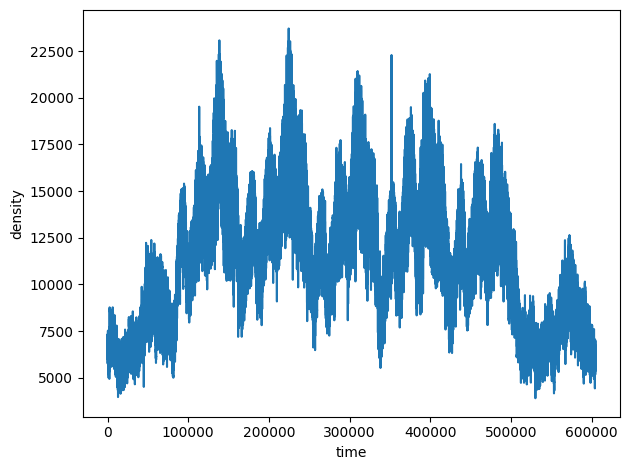

In [109]:
import numpy as np
import matplotlib.pyplot as plt

def plot_density(value_arr, time_arr, window_size=500):
    # Convert to plain numpy arrays (avoids pandas index alignment & rtruediv)
    value_arr = np.asarray(value_arr)
    time_arr = np.asarray(time_arr)

    # Trim to same length
    N = min(len(value_arr), len(time_arr))
    value_arr = value_arr[:N]
    time_arr = time_arr[:N]

    if N < window_size:
        raise ValueError("window_size larger than array length")

    # 1. Sliding sum of values (sliding inner product)
    window = np.ones(window_size, dtype=float)
    value_sum = np.correlate(value_arr, window, mode="valid")  # shape: (N - W + 1,)

    # 2. Matching time span: t[i+W-1] - t[i], aligned with the same i as value_sum
    time_start = time_arr[: N - window_size + 1]    # shape: (N - W + 1,)
    time_end   = time_arr[window_size - 1 : N]      # shape: (N - W + 1,)
    time_diff  = time_end - time_start              # shape: (N - W + 1,)

    # 3. Density
    value_per_s = value_sum / time_diff

    # Optional: time axis as window centers
    t_mid = 0.5 * (time_start + time_end)

    plt.plot(t_mid, value_per_s)
    plt.xlabel("time")
    plt.ylabel("density")
    plt.tight_layout()

plot_density(token_arr, time_arr)

In [133]:
def extract_data(time_arr, value_arr, time_start, time_end, machine_numbers):
    idx_beg = np.searchsorted(time_arr, time_start)
    idx_end = np.searchsorted(time_arr, time_end)
    print(f"{idx_beg=} {idx_end=} {idx_end-idx_beg=} {sum(value_arr[idx_beg:idx_end])/(time_end-time_start)/machine_numbers=:.2f}")

    if idx_end - idx_beg < machine_numbers:
        print(f"{idx_end=} - {idx_beg=} < {machine_numbers=}")
        machine_numbers = idx_end - idx_beg

    idx_one_machine = np.arange(idx_beg, idx_end, machine_numbers)
    return time_arr[idx_one_machine].tolist(), value_arr[idx_one_machine].tolist()

def assemble_data(time_arr, value_arr, target_file):
    print(time_arr)
    selected_tokens = ["Apple", "Banana", "Machine", "Trace", "Abandon", "Wonderful"]
    csv_lines = [["timestamp", "text"]]
    for i in range(len(time_arr)):
        t = time_arr[i]
        len_tok = value_arr[i]
        token_str = " ".join(( \
            selected_tokens * (len_tok // len(selected_tokens)) + selected_tokens[:len_tok % len(selected_tokens)]
        )) 
        csv_lines.append([t, token_str])
    with open(target_file, "w") as f:
        writer = csv.writer(f)
        writer.writerows(csv_lines)
    

for i in range(5):
    assemble_data(
        *extract_data(time_arr, token_arr, time_start=100000+i*60, time_end=100000+(i+1)*60, machine_numbers=4),
        f"./dataset/realdata_downsample/sampled.{i}.csv"
    )

idx_beg=1577724 idx_end=1578977 idx_end-idx_beg=1253 sum(value_arr[idx_beg:idx_end])/(time_end-time_start)/machine_numbers=2556.02
[100000.02141308784, 100000.24431610107, 100000.37249493599, 100000.63092207909, 100000.7433040142, 100000.87329602242, 100000.99520492554, 100001.20728492737, 100001.40644097328, 100001.49338912964, 100001.7157239914, 100001.86716294289, 100002.11413502693, 100002.1318371296, 100002.21270298958, 100002.37282395363, 100002.6106209755, 100002.70848107338, 100003.11051893234, 100003.20260500908, 100003.36400413513, 100003.51047801971, 100003.70107913017, 100003.85700201988, 100004.00241208076, 100004.11628508568, 100004.20264792442, 100004.25603199005, 100004.46868610382, 100004.6207780838, 100004.85334014893, 100004.99865603447, 100005.36992192268, 100005.40039801598, 100005.74308896065, 100005.95130896568, 100006.12052202225, 100006.21769094467, 100006.45333313942, 100006.61896514893, 100006.90867304802, 100007.00172805786, 100007.13000392914, 100007.216881